###NATURAL LANGUAGE INFERENCING with WATSON PROJECT
####Content
####1. Data Preprocesing & Exploration
####2. Use Sequence2Squence model (Bi-LSTM/ M-BERT) to preform NLI task
####3. Use BERT (XLM-RoBERTa) to build model & preform NLI task
####4. Summary

######UTILS

In [40]:
# !pip uninstall tensorflow_text
# !pip uninstall tensorflow==1.15
# !pip uninstall "tensorflow_hub>=0.6.0"
# !pip3 uninstall tensorflow_text==1.15
!pip3 uninstall tensorflow
!pip3 install tensorflow-gpu==1.13.1

!pip3 uninstall tensorflow_hub
!pip3 install tensorflow_hub==0.1.1

!pip3 uninstall keras
!pip3 install keras==2.2.0

# !pip3 uninstall numpy
# !pip3 install numpy

     |████████████████████████████████| 394.3 MB 7.1 kB/s 
     |████████████████████████████████| 6.0 MB 23.6 MB/s 
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
     |████████████████████████████████| 462 kB 21.7 MB/s 
     |████████████████████████████████| 14.8 MB 186 kB/s 
     |████████████████████████████████| 3.9 MB 22.5 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.2
    Uninstalling numpy-1.20.2:
      Successfully uninstalled numpy-1.20.2
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.13.0
    Uninstalling tensorflow-estimator-1.13.0:
      Successfully uninstalled tensorflow-estimator-1.13.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.13.1
    Uninstalling tensorboard-1.13.1:
      Successfully uninstalled tensorboard-1.13.1
  Attempting uninstall: keras-preprocessing
    Found existing installation: Keras-Preprocessing 1.0.1

Found existing installation: tensorflow-hub 0.1.1
Uninstalling tensorflow-hub-0.1.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/tensorflow_hub-0.1.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow_hub/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-hub-0.1.1
  Using cached tensorflow_hub-0.1.1-py2.py3-none-any.whl (52 kB)


Found existing installation: Keras 2.2.0
Uninstalling Keras-2.2.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/Keras-2.2.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/docs/*
    /usr/local/lib/python3.7/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.7/dist-packages/docs/update_docs.py
Proceed (y/n)? y
  Successfully uninstalled Keras-2.2.0


In [2]:
!pip install --upgrade pip
!pip install --upgrade allennlp
!pip install transformers==4.3.0
# !pip install transformers
# !pip install tensorflow==1.15
# !pip install "tensorflow_hub>=0.6.0"
# !pip3 install tensorflow_text==1.15

     |████████████████████████████████| 1.6MB 6.5MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 625 kB 5.2 MB/s 
     |████████████████████████████████| 2.1 MB 8.7 MB/s 
     |████████████████████████████████| 120 kB 35.7 MB/s 
     |████████████████████████████████| 259 kB 36.7 MB/s 
     |████████████████████████████████| 1.2 MB 33.7 MB/s 
     |████████████████████████████████| 131 kB 70.2 MB/s 
     |████████████████████████████████| 2.1 MB 45.3 MB/s 
     |████████████████████████████████| 7.5 MB 55.6 MB/s 
     |████████████████████████████████| 79 kB 6.1 MB/s 
     |████████████████████████████████| 153 kB 76.8 MB/s 
     |████████████████████████████████| 127 kB 47.6 MB/s 
     |████████████████████████████████| 895 kB 60.3 MB/s 
     |████████████████████████████████| 3.3 MB 38.0 MB/s 
     |████████████████████████████████| 97 kB 4.8 MB/s 
     |████████████████████

     |████████████████████████████████| 1.8 MB 5.2 MB/s 
  Attempting uninstall: transformers
    Found existing installation: transformers 4.5.1
    Uninstalling transformers-4.5.1:
      Successfully uninstalled transformers-4.5.1


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from transformers import AutoTokenizer, BertTokenizer, TFAutoModel, TFBertModel,AutoConfig, XLMRobertaConfig, XLMRobertaTokenizer, TFXLMRobertaModel
from tokenizers import BertWordPieceTokenizer
from sklearn.model_selection import StratifiedKFold,train_test_split
import transformers
import os
from keras.layers import *
import matplotlib.pyplot as plt
import keras.layers as layers
from keras.models import Model
from keras.models import load_model
from keras.optimizers import Adam
# import tensorflow.keras.backend as K
from keras import backend as K
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_recall_fscore_support
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# from keras.models import Sequential
from tensorflow.keras.models import Sequential
# import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [2]:
class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        sentence_pairs: Array of premise and hypothesis input sentences.
        labels: Array of labels.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the labels.

    Returns:
        Tuples `([input_ids, attention_mask, `token_type_ids], labels)`
        (or just `[input_ids, attention_mask, `token_type_ids]`
         if `include_targets=False`)
    """

    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=32,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-multilingual-cased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)

def plot_classification_report(y_tru, y_prd, figsize=(10, 6), ax=None):
    plt.figure(figsize=figsize)
    plt.tick_params(axis='both', which='major', labelsize=13)
    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = list(np.unique(y_tru))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_true=y_tru, y_pred=y_prd)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    sns.heatmap(rep,
                annot=True, 
                cbar=False, 
                xticklabels=xticks, 
                yticklabels=yticks,
                ax=ax)

In [3]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
sample_sub = pd.read_csv("./sample_submission.csv")

######1. Data Preprocessing & Exploration

In [8]:
train.head(5)

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [9]:
print("Number of training data rows: {} \n".format(train.shape[0]))
print("Number of training data columns: {} \n".format(train.shape[1]))
print("Number of test data rows: {} \n".format(test.shape[0]))
print("Number of test data columns: {} \n".format(test.shape[1]))

Number of training data rows: 12120 

Number of training data columns: 6 

Number of test data rows: 5195 

Number of test data columns: 5 



In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5195 entries, 0 to 5194
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5195 non-null   object
 1   premise     5195 non-null   object
 2   hypothesis  5195 non-null   object
 3   lang_abv    5195 non-null   object
 4   language    5195 non-null   object
dtypes: object(5)
memory usage: 203.1+ KB


Text(0.13, 0.95, 'Train vs Test: Language Count')

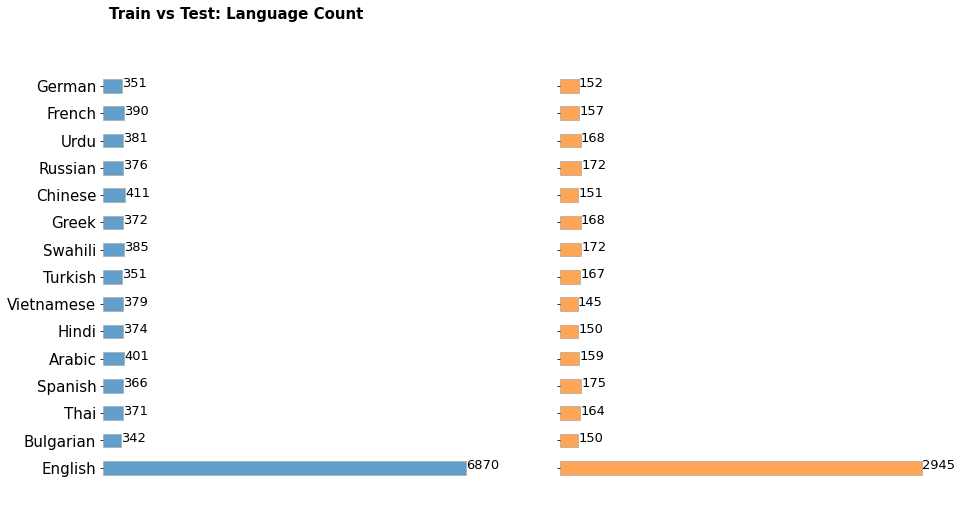

In [12]:
train_language_cnt = train['language'].value_counts(sort=False)
test_language_cnt = test['language'].value_counts(sort=False)[train_language_cnt.index]
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,8),sharey=True)
for i,cnt in enumerate([train_language_cnt,test_language_cnt]):
    axes[i].barh(cnt.index,cnt.values,
            height=0.5, edgecolor='darkgrey',
            color=sns.color_palette()[i],alpha=0.7)
    axes[i].set_yticklabels(cnt.index,fontsize=15)
    axes[i].set_xticks([])

    for j in axes[i].patches:
        axes[i].text(j.get_width()+.5, j.get_y()+.2,
                str(j.get_width()), 
                fontsize=13, color='black')

    for pos in ['left','right','bottom','top']:
        axes[i].spines[pos].set_color(None)

fig.text(0.13, 0.95, 'Train vs Test: Language Count', fontsize=15, fontweight='bold') 

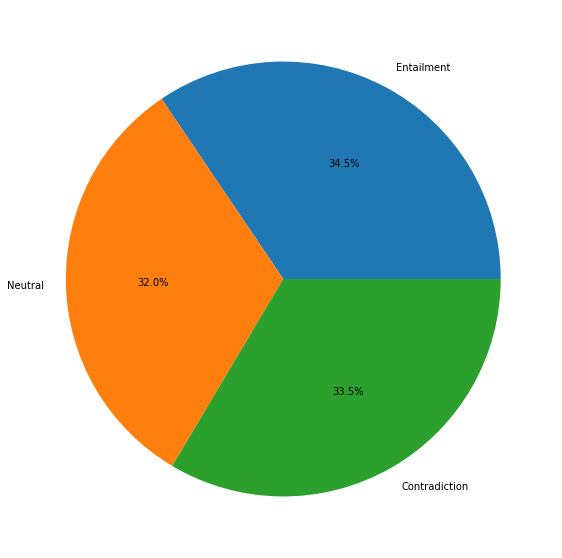

In [13]:
label_cnt = train['label'].value_counts()
class_labels = ['Entailment', 'Neutral', 'Contradiction']
counts_per_class = [label_cnt[0], label_cnt[1], label_cnt[2]]

plt.figure(figsize = (10,10))
plt.pie(counts_per_class,labels = class_labels, autopct = '%1.1f%%')
plt.show()

In [14]:
fig = make_subplots(rows=5, cols=3, specs=[[{"type": "domain"}]*3]*5,
                    horizontal_spacing=0.005,vertical_spacing=0.01)
for i,lang in enumerate(list(train_language_cnt.index)): 
    label_cnt = train[train.language == lang]['label'].value_counts()
    fig.add_trace(go.Pie(labels = label_cnt.index, 
                   values = label_cnt.values,
                   hoverinfo = 'percent+value+label',
                   textinfo = 'percent',
                   textposition = 'inside',
                   textfont = dict(size=14),
                   title = lang,
                   titlefont = dict(size=15),
                   hole = 0.5,
                   showlegend = True,
                   marker = dict(line=dict(color='black',width=2))),
                   row=divmod(i,3)[0]+1,col=divmod(i,3)[1]+1)
fig.update_layout(height=750, width=750)
fig.show()

+ The distribution of train labels is balanced on the whole and in different languages.

+ Token count for training & test 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.13, 0.95, 'Train: Premise & Hypothesis Word Count')

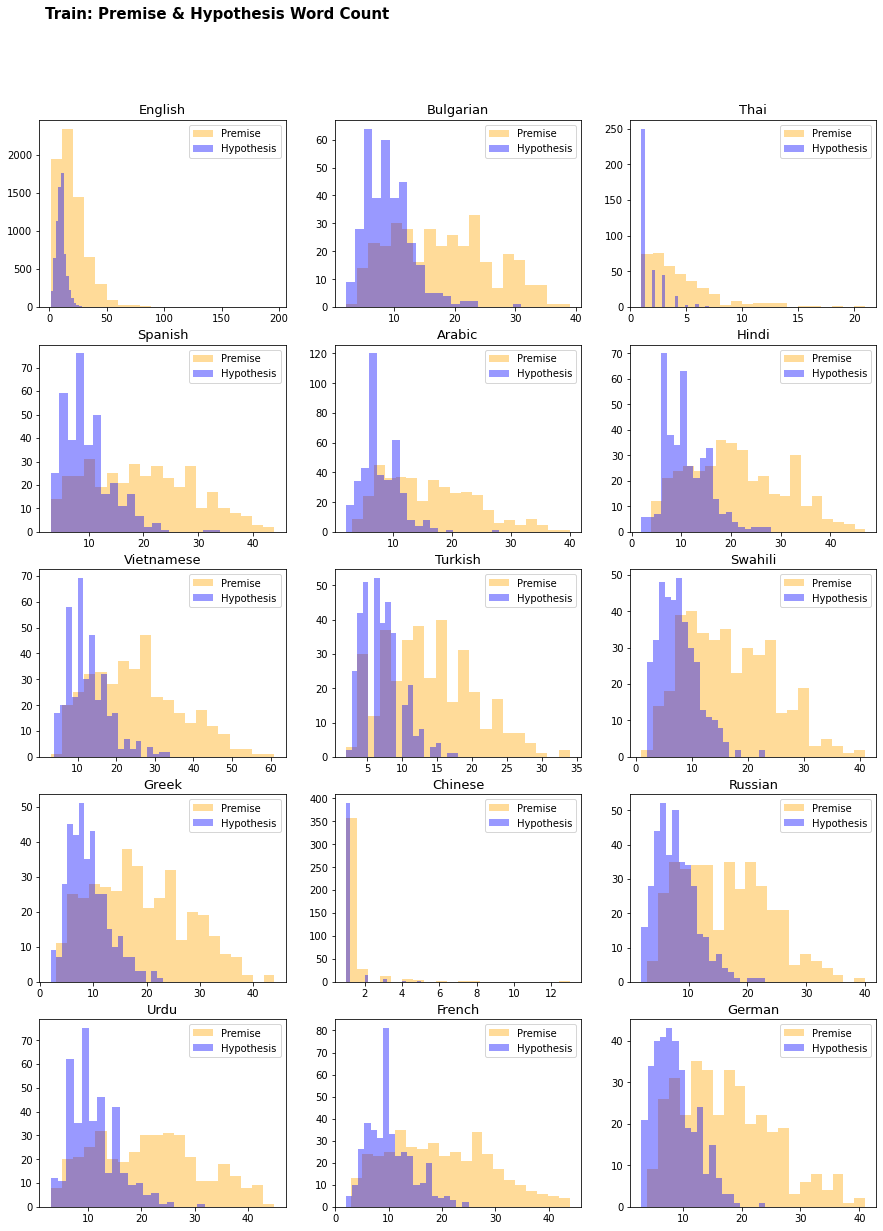

In [15]:
train['premise_word_cnt'] = train['premise'].apply(lambda x: len(x.split()))
train['hypothesis_word_cnt'] = train['hypothesis'].apply(lambda x: len(x.split()))

fig,ax = plt.subplots(nrows=5,ncols=3,figsize=(15,20))
for i,lang in enumerate(list(train_language_cnt.index)):
    sns.distplot(train[train.language == lang]['premise_word_cnt'],bins=20,
                 color='orange',label='Premise',kde=False, ax=ax[divmod(i,3)[0],divmod(i,3)[1]])
    sns.distplot(train[train.language == lang]['hypothesis_word_cnt'],bins=20,
                 color='blue',label='Hypothesis',kde=False, ax=ax[divmod(i,3)[0],divmod(i,3)[1]])
    ax[divmod(i,3)[0],divmod(i,3)[1]].set_title(lang,fontsize=13)
    ax[divmod(i,3)[0],divmod(i,3)[1]].legend()
    ax[divmod(i,3)[0],divmod(i,3)[1]].set_xlabel('')
fig.text(0.13, 0.95, 'Train: Premise & Hypothesis Word Count', fontsize=15, fontweight='bold')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.13, 0.95, 'Test: Premise & Hypothesis Word Count')

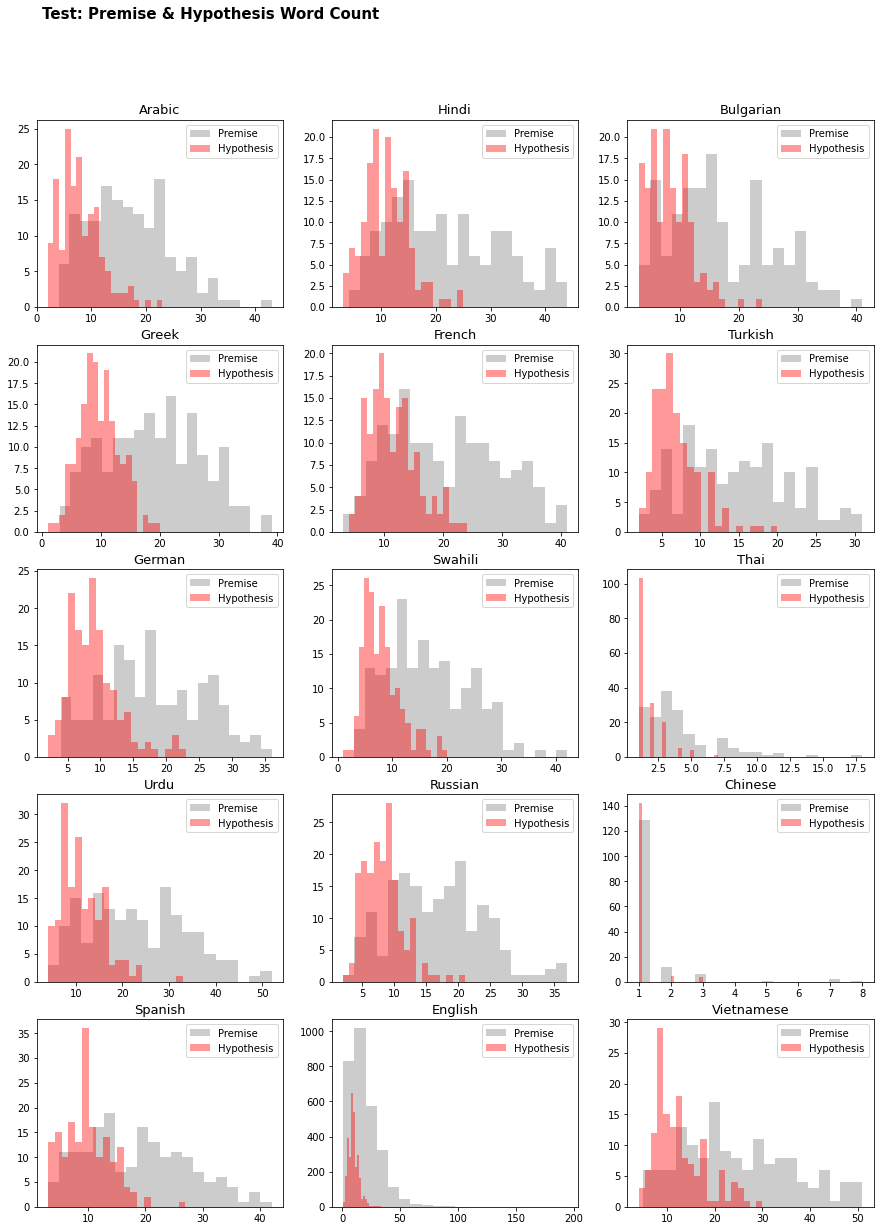

In [15]:
test['premise_word_cnt'] = test['premise'].apply(lambda x: len(x.split()))
test['hypothesis_word_cnt'] = test['hypothesis'].apply(lambda x: len(x.split()))

fig,ax = plt.subplots(nrows=5,ncols=3,figsize=(15,20))
for i,lang in enumerate(list(test_language_cnt.index)):
    sns.distplot(test[test.language == lang]['premise_word_cnt'],bins=20,
                 color='gray',label='Premise',kde=False, ax=ax[divmod(i,3)[0],divmod(i,3)[1]])
    sns.distplot(test[test.language == lang]['hypothesis_word_cnt'],bins=20,
                 color='red',label='Hypothesis',kde=False, ax=ax[divmod(i,3)[0],divmod(i,3)[1]])
    ax[divmod(i,3)[0],divmod(i,3)[1]].set_title(lang,fontsize=13)
    ax[divmod(i,3)[0],divmod(i,3)[1]].legend()
    ax[divmod(i,3)[0],divmod(i,3)[1]].set_xlabel('')
fig.text(0.13, 0.95, 'Test: Premise & Hypothesis Word Count', fontsize=15, fontweight='bold')

In [6]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name) # Save the slow pretrained tokenizer
save_path = '.'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path) # Save the loaded tokenizer locally
tokenizer = BertWordPieceTokenizer("vocab.txt", lowercase=False, strip_accents=False) # Load the fast tokenizer from saved file
tokenizer

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=False, lowercase=False, wordpieces_prefix=##)

In [17]:
tokenized_premise = tokenizer.encode_batch(train.premise.values.tolist()) # list of encoding objects
train['premise_seq_length'] = [len(encoding.tokens) for encoding in tokenized_premise] # list of lengths
    
tokenized_hypothesis = tokenizer.encode_batch(train.hypothesis.values.tolist()) # list of encoding objects
train['hypothesis_seq_length'] = [len(encoding.tokens) for encoding in tokenized_hypothesis] # list of lengths

# Calculate max and avg sequence length per language
info_per_lang = train.groupby('language').agg({'premise_seq_length': ['mean', 'max', 'count'], 'hypothesis_seq_length': ['mean', 'max', 'count']})
print (info_per_lang)

           premise_seq_length            hypothesis_seq_length          
                         mean  max count                  mean max count
language                                                                
Arabic              36.286783   96   401             18.658354  65   401
Bulgarian           39.564327   89   342             20.809942  56   342
Chinese             33.206813   78   411             17.311436  48   411
English             28.189520  234  6870             15.034352  61  6870
French              32.951282   81   390             17.951282  41   390
German              30.843305   73   351             16.316239  40   351
Greek               51.365591  110   372             26.314516  68   372
Hindi               43.427807  104   374             22.922460  53   374
Russian             36.468085   88   376             18.723404  54   376
Spanish             30.169399   62   366             16.095628  47   366
Swahili             36.187013   88   385           

+ The length should be large enough such that we don’t lose much data. Additionally, a very big number would make the model complex.

+ Since most of the inputs are shorter than 50 words, we can consider length 50 for each input type of hypothesis and premise.

+ MAX_LEN=100.

In [4]:
train, dev = train_test_split(train, stratify=train.label.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)


train.reset_index(drop=True, inplace=True)
dev.reset_index(drop=True, inplace=True)

In [7]:
dev.head(5)
# dev.shape

,id,premise,hypothesis,lang_abv,language,label
0,e591a77c6c,ดังนั้น สำนักงานตัวแทนสหภาพต้องการคิดทบทวนการป...,ตัวแทนของรัฐบาลกลางมีทรัพยากรมนุษย์ที่เพียงพอ,th,Thai,2
1,b8198e0a5d,and uh as a matter of fact he's a draft dodger,"They dodged the draft, I'll have you know.",en,English,0
2,6c46429835,"Шефе, той беше като човек с раздвоена личност.","Шефът ми беше или наистина щастлив, или наисти...",bg,Bulgarian,1
3,b9fcf02f32,"Nichts kommt von nichts, behauptete Lukrez vor...",Die Argumente von Lecretius wurden von Tautolo...,de,German,2
4,b82c59d12d,مالی سال 2000 کانگریس اور امریکی ٹیکس دہندہ کے...,2000 اب تک کا سب سے برا سال تھا۔,ur,Urdu,2


######2. Sequence2sequence Model (Bidirectional LSTM)

+ Draft

In [3]:
# import tensorflow.compat.v1 as tf_com
# tf_com.disable_v2_behavior()
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

1.13.1
2.2.4-tf


In [9]:
# class ElmoEmbeddingLayer(Layer):
#     def __init__(self, **kwargs):
#         self.dimensions = 1024
#         self.trainable=True
#         super(ElmoEmbeddingLayer, self).__init__(**kwargs)

#     def build(self, input_shape):
#         self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
#                                name="{}_module".format(self.name))

#         self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
#         super(ElmoEmbeddingLayer, self).build(input_shape)

#     def call(self, x, mask=None):
#         result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
#                       as_dict=True,
#                       signature='default',
#                       )['default']
#         return result

#     def compute_mask(self, inputs, mask=None):
#         return K.not_equal(inputs, '--PAD--')

#     def compute_output_shape(self, input_shape):
#         return (input_shape[0], self.dimensions)

# class NonMasking(Layer):   
#     def __init__(self, **kwargs):   
#         self.supports_masking = True  
#         super(NonMasking, self).__init__(**kwargs)   
  
#     def build(self, input_shape):   
#         input_shape = input_shape   
  
#     def compute_mask(self, input, input_mask=None):   
#         # do not pass the mask to the next layers   
#         return None   
  
#     def call(self, x, mask=None):   
#         return x   
  
#     def get_output_shape_for(self, input_shape):   
#         return input_shape
    
#     def get_config(self):
#         config = {'output_dim': self.output_dim}
        
# custom_ob={'ElmoEmbeddingLayer': ElmoEmbeddingLayer, 'NonMasking': NonMasking}

In [ ]:
# elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
# def elmo_vectors(x):
#   embeddings = elmo(x.tolist(), signature="default", as_dict=True)["elmo"]

#   with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     sess.run(tf.tables_initializer())
    # return average of ELMo features
    # return sess.run(tf.reduce_mean(embeddings,1))

In [ ]:
# list_train = [train[i:i+100] for i in range(0,train.shape[0],100)]
# inp1 = [elmo_vectors(x['premise']) for x in list_train]

# inp2 = [elmo_vectors(x['hypothesis']) for x in list_train]

In [ ]:
# model = Sequential()
# inp1 = Input(shape=(1,), name="premise")
# inp2 = Input(shape=(1,), name="hypothesis")
# tf.compat.v1.disable_eager_execution()

# def emb_layer(inp, col):
#     x = ElmoEmbeddingLayer()(inp)
    # x = Embedding(V_SIZE, 300, max_len=75)(inp)
    # return x

# x = concatenate([inp1,inp2])

# x = NonMasking()(x)
# x = Reshape((1, 1024*2), input_shape=(1024*2,))(x)
# x = Bidirectional(LSTM(128, return_sequences=True,recurrent_dropout=0.2))(x)
# x = Bidirectional(LSTM(128, return_sequences=True,recurrent_dropout=0.2))(x)
# x = Bidirectional(LSTM(128, return_sequences=True,recurrent_dropout=0.2))(x)
# x = Bidirectional(LSTM(128, return_sequences=True,recurrent_dropout=0.2))(x)

# avg_pool = GlobalAveragePooling1D()(x)
# max_pool = GlobalMaxPooling1D()(x)
# x = concatenate([avg_pool, max_pool])

# outp = Dense(3, activation="softmax", name="final_output")(x)

# model = Model(inputs=[inp1,inp2], outputs=outp)
# model.compile(loss='categorical_crossentropy',
#               optimizer=Adam(lr=0.001),
#               metrics=['accuracy'],
#               )
# model.summary()

# # CALLBACK
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
#                                             patience=1, 
#                                             verbose=1, 
#                                             factor=0.5,
#                                             min_lr=0.00001)
# file_path="checkpoint_NLIWS_weights.hdf5"
# checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
# early = EarlyStopping(monitor="val_acc", mode="max", patience=1)

# model_callbacks = [checkpoint, early, learning_rate_reduction]



In [29]:
# def get_data(df):
#     x = {
#         'premise': df["premise"],
#         'hypothesis': df["hypothesis"]
#         }
#     return x

# le = LabelEncoder()

# X_train = get_data(train)
# Y_train = np_utils.to_categorical(le.fit_transform(train["label"].values)).astype("int64")

# X_dev = get_data(dev)
# Y_dev = np_utils.to_categorical(le.fit_transform(dev["label"].values)).astype("int64")

In [ ]:
# model.fit(X_train, Y_train,
#           batch_size=128,
#           epochs=2,
#           verbose=2,
#           validation_data=(X_dev, Y_dev),
#           callbacks = model_callbacks
#          )

+ Bi-LSTM with BERT output

In [5]:
max_length = 100  # Maximum length of input sentence to the model.
batch_size = 32
# epochs = 2

In [9]:
y_train = tf.keras.utils.to_categorical(train.label, num_classes=3)
train_data = BertSemanticDataGenerator(
    train[["premise", "hypothesis"]].values.astype("str"),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)

y_dev = tf.keras.utils.to_categorical(dev.label, num_classes=3)
dev_data = BertSemanticDataGenerator(
    dev[["premise", "hypothesis"]].values.astype("str"),
    y_dev,
    batch_size=batch_size,
    shuffle=True,
)



In [16]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Encoded token ids from BERT tokenizer.
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
    # Token type ids are binary masks identifying different sequences in the model.
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids"
    )
    # Loading pretrained BERT model.
    bert_model = transformers.TFBertModel.from_pretrained("bert-base-multilingual-cased")
    # Freeze the BERT model to reuse the pretrained features without modifying them.
    bert_model.trainable = False

    sequence_output = bert_model(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )[0]
    # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
    bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(sequence_output)
    # Applying hybrid pooling approach to bi_lstm sequence output.
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)
    output = tf.keras.layers.Dense(3, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks, token_type_ids], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )


print(f"Strategy: {strategy}")
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [12]:
filepath='LSTM_best_weight.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                                                save_best_only=True, save_weights_only=True, 
                                                mode='min',save_freq = 'epoch')

In [13]:
history = model.fit(
    train_data,
    validation_data=dev_data,
    epochs=2,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint],
    workers=-1,
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



Epoch 1/2
303/303 [==============================] - ETA: 0s - loss: 1.1174 - acc: 0.3732 

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


303/303 [==============================] - 4538s 15s/step - loss: 1.1173 - acc: 0.3733 - val_loss: 1.0082 - val_acc: 0.5033

Epoch 00001: val_loss improved from inf to 1.00821, saving model to LSTM_best_weight.hdf5
Epoch 2/2
303/303 [==============================] - 4513s 15s/step - loss: 0.9978 - acc: 0.5151 - val_loss: 0.9221 - val_acc: 0.5800

Epoch 00002: val_loss improved from 1.00821 to 0.92212, saving model to LSTM_best_weight.hdf5


In [10]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [17]:
# model = create_model()
model.load_weights("./gdrive/MyDrive/LSTM_best_weight.hdf5")

In [37]:
dev1=dev.head(100)
# dev.shape

In [38]:
# y_dev = tf.keras.utils.to_categorical(dev.label, num_classes=3)
# sentence_pairs = np.array([[str(dev['premise']), str(dev['hypothesis'])]])
dev_data_ = BertSemanticDataGenerator(
    dev1[["premise", "hypothesis"]].values.astype("str"),
    # sentence_pairs,
    # y_dev,
    labels=None,
    include_targets=False,
    batch_size=1,
    shuffle=False
)

dev_predictions = [np.argmax(i) for i in model.predict(dev_data_)] #predictions
dev_labels = dev1.label.values.tolist() #ground truth labels

target_class = ['entailment' if label==0 else 'neutral' if label==1 else 'contradiction' for label in dev_labels]
prediction_class = ['entailment' if label==0 else 'neutral' if label==1 else 'contradiction' for label in dev_predictions]
print('\nClassification Report')
print(classification_report(y_true=target_class, y_pred=prediction_class))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).




Classification Report
               precision    recall  f1-score   support

contradiction       0.58      0.61      0.59       336
   entailment       0.65      0.63      0.64       345
      neutral       0.57      0.56      0.56       319

     accuracy                           0.60      1000
    macro avg       0.60      0.60      0.60      1000
 weighted avg       0.60      0.60      0.60      1000



Classification Report
               
               precision    recall  f1-score   support

    contradiction       0.58      0.61      0.59       336
    entailment       0.65      0.63      0.64       345
    neutral       0.57      0.56      0.56       319

    accuracy                           0.60      1000
    macro avg       0.60      0.60      0.60      1000
    weighted avg       0.60      0.60      0.60      1000


######3. BERT model (XML-RoBERTa)



In [6]:
# Hyperparameter
EPOCHS = 2
BATCH_SIZE = 64 
MAX_LEN = 60
PATIENCE = 1
LEARNING_RATE = 1e-5

PRETRAINED_MODEL_TYPES = {
    'xlmroberta': (XLMRobertaConfig, TFXLMRobertaModel, XLMRobertaTokenizer, 'jplu/tf-xlm-roberta-large')
}

config_class, model_class, tokenizer_class, model_name = PRETRAINED_MODEL_TYPES['xlmroberta']

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name) #fast tokenizer

In [8]:
def encode(df, tokenizer, max_len=50):
    
    pairs = df[['premise','hypothesis']].values.tolist() #shape=[num_examples]
    
    print ("Encoding...")
    encoded_dict = tokenizer.batch_encode_plus(pairs, max_length=max_len, padding=True, truncation=True, 
                                               add_special_tokens=True, return_attention_mask=True)
    print ("Complete")
    
    input_word_ids = tf.convert_to_tensor(encoded_dict['input_ids'], dtype=tf.int32) #shape=[num_examples, max_len])
    input_mask = tf.convert_to_tensor(encoded_dict['attention_mask'], dtype=tf.int32) #shape=[num_examples, max_len]
    
    inputs = {
        'input_word_ids': input_word_ids,
        'input_mask': input_mask}    
    
    return inputs

In [9]:
train_ = train.head(100)
# dev_ = dev.head(10)

In [ ]:
train_input = encode(train_, tokenizer=tokenizer, max_len=MAX_LEN)
dev_input = encode(dev, tokenizer=tokenizer, max_len=MAX_LEN)

In [12]:
def build_model(max_len=100):
    
    tf.random.set_seed(12345) # For reproducibility
    
    # The bare XLM-RoBERTa Model transformer outputting raw hidden-states without any specific head on top.
    encoder = model_class.from_pretrained(model_name)
#     encoder = TFAutoModel.from_pretrained(model_name)
    
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    
    # Extract pretrained embedding vectors
    embedding = encoder([input_word_ids, input_mask])[0] # shape=(batch_size, max_len, embed_size)
    # We pass the embedding vectors of only the 'cls' token (at index=0) to the dense layer
    sequence_output = embedding[:,0,:] #shape=(batch_size, embed_size)
   
    # Add a classification layer
    output = tf.keras.layers.Dense(3, activation="softmax")(sequence_output)  
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except ValueError:
#     strategy = tf.distribute.get_strategy() # for CPU and single GPU
# print('Number of replicas:', strategy.num_replicas_in_sync)

In [13]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = build_model(MAX_LEN)
    model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Some layers from the model checkpoint at jplu/tf-xlm-roberta-large were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [ ]:
checkpoint_filepath='xlmroberta_best_weight.hdf5'

callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE), ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)]

xmlb_history = model.fit(x=train_input, y=train_.label.values, 
                         validation_data=(dev_input, dev.label.values), 
                         epochs=EPOCHS, verbose=1, batch_size=10, callbacks=callbacks)

Epoch 1/2
10/10 [==============================] - ETA: 0s - loss: 1.2149 - accuracy: 0.3243 WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


In [ ]:
dev1 = dev.head(100)
dev_input_ = encode(dev1, tokenizer=tokenizer, max_len=MAX_LEN)

dev_predictions = [np.argmax(i) for i in model.predict(dev_input_)] #predictions
dev_labels = dev1.label.values.tolist() #ground truth labels

target_class = ['entailment' if label==0 else 'neutral' if label==1 else 'contradiction' for label in dev_labels]
prediction_class = ['entailment' if label==0 else 'neutral' if label==1 else 'contradiction' for label in dev_predictions]
print('\nClassification Report for XLM-ROBERTa')
print(classification_report(y_true=target_class, y_pred=prediction_class))

Classification Report for XLM-ROBERTa

                     precision    recall  f1-score   support

     contradiction       0.91      0.74      0.82       813
     entailment       0.80      0.81      0.81       835
     neutral       0.69      0.82      0.75       776

     accuracy                           0.79      2424
     macro avg       0.80      0.79      0.79      2424
     weighted avg       0.80      0.79      0.79      2424


######4. SUMMARY

+ LSTM + M-BERT has performance worst than XLM-ROBERTa